In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from itertools import product
import gc
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from catboost import CatBoostRegressor
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


        
        
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    #float_cols = [c for c in df if df[c].dtype == "float32"]
    #int_cols =   [c for c in df if df[c].dtype == "int32"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))
# Any results you write to the current directory are saved as output.

In [8]:
DATA_FOLDER = './kaggle/input/competitive-data-science-predict-future-sales/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'), parse_dates = True)
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
en              = pd.read_csv(os.path.join(DATA_FOLDER, 'item_category_en.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))

test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

In [12]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = transactions.loc[transactions['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = transactions.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

In [115]:
all_data.head()

,item_id,shop_id,date_block_num,target,target_shop,target_item,target_item_shop,item_category_id,target_category
0,0,5,20,0.0,1355.0,0.020004,0.0,40,214.0
1,0,4,20,0.0,1090.0,0.020004,0.0,40,98.0
2,0,6,20,0.0,2754.0,0.020004,0.0,40,273.0
3,0,2,20,0.0,920.0,0.020004,0.0,40,38.0
4,0,3,20,0.0,960.0,0.020004,0.0,40,90.0


In [116]:
test.head()

,item_id,ID,shop_id,item_category_id,target,date_block_num,target_shop,target_item,target_category,target_item_shop
50190,5037,0,5,0,0,34,0,0,0,0
52668,5320,1,5,0,0,34,0,0,0,0
52038,5233,2,5,0,0,34,0,0,0,0
51996,5232,3,5,0,0,34,0,0,0,0
52290,5268,4,5,0,0,34,0,0,0,0


In [81]:
len(all_data[(all_data["item_id"] == 2252) & (all_data["date_block_num"] == 0)])

45

In [82]:
all_data[(all_data["item_id"] == 2252) & (all_data["date_block_num"] == 0)]["target"].sum()

177.0

In [13]:


# Same as above but with shop-month aggregates
gb = all_data.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'target':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
#gb = transactions.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})

gb = all_data.groupby(['item_id', 'date_block_num'],as_index=False).agg({'target':{'target_item':'mean'}})

gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)


# Same as above but with item-month aggregates
#gb = transactions.groupby(['item_id', "shop_id", 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item_shop':'sum'}})
gb = all_data.groupby(['item_id', "shop_id", 'date_block_num'],as_index=False).agg({'target':{'target_item_shop':'mean'}})

gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', "shop_id", 'date_block_num']).fillna(0)

#test = test.merge(items, how="left", on="item_id")

#all_data.drop("item_name", inplace=True, axis=1)
#test.drop("item_name", inplace=True, axis=1)

# Same as above but with item-month aggregates

#transactions = transactions.set_index("item_id").join(items.set_index("item_id"))

#transactions.drop("item_name", inplace=True, axis=1)

#transactions.reset_index(inplace=True)

all_data = all_data.set_index("item_id").join(items.set_index("item_id"))

all_data.drop("item_name", inplace=True, axis=1)

all_data.reset_index(inplace=True)


gb = all_data.groupby(['shop_id', 'item_category_id', 'date_block_num'],as_index=False).agg({'target':{'target_category':'sum'}})

gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]

#print (gb.head())
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'item_category_id', 'date_block_num']).fillna(0)


# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [21]:
test = test.set_index("item_id").join(items.set_index("item_id"))

test.drop("item_name", inplace=True, axis=1)

test.reset_index(inplace=True)

#transactions = transactions.rename(columns = {'item_cnt_day' : 'item_cnt_month'})


test.sort_values("ID", inplace=True)

test["target"] =0
test["date_block_num"] = transactions["date_block_num"].max() + 1
test["target_shop"] = 0
test["target_item"] = 0
test["item_category_id"] = 0
test["target_category"] = 0
test["target_item_shop"] = 0

train_test_together = pd.concat([all_data, test])



/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [22]:
all_data[(all_data["item_id"]== 2252) & (all_data["date_block_num"] == 17)]

,item_id,shop_id,date_block_num,target,target_shop,target_item,target_item_shop,item_category_id,target_category
934198,2252,26,17,2.0,1598.0,1.713867,2.0,30,213.0
934199,2252,27,17,2.0,4280.0,1.713867,2.0,30,627.0
934200,2252,25,17,2.0,6404.0,1.713867,2.0,30,511.0
934201,2252,24,17,2.0,1708.0,1.713867,2.0,30,276.0
934202,2252,31,17,6.0,7700.0,1.713867,6.0,30,766.0
934203,2252,30,17,2.0,1775.0,1.713867,2.0,30,241.0
934204,2252,29,17,2.0,1430.0,1.713867,2.0,30,145.0
934205,2252,59,17,1.0,1157.0,1.713867,1.0,30,251.0
934206,2252,28,17,3.0,5700.0,1.713867,3.0,30,480.0
934207,2252,5,17,2.0,1326.0,1.713867,2.0,30,221.0


In [20]:
train_test_together.head()

,ID,date_block_num,item_category_id,item_id,shop_id,target,target_category,target_item,target_item_shop,target_shop
0,NaN,20,40,0,5,0.0,214.0,0.020004,0.0,1355.0
1,NaN,20,40,0,4,0.0,98.0,0.020004,0.0,1090.0
2,NaN,20,40,0,6,0.0,273.0,0.020004,0.0,2754.0
3,NaN,20,40,0,2,0.0,38.0,0.020004,0.0,920.0
4,NaN,20,40,0,3,0.0,90.0,0.020004,0.0,960.0


In [68]:
all_data[(all_data["item_id"] == 2252) & (all_data["date_block_num"] == 12)]["target"].sum()

102.0

In [12]:
assert len(all_data) == 11128050

In [16]:
all_data = all_data.astype(int)

In [8]:
all_data.head()

,ID,date_block_num,item_category_id,item_id,shop_id,target,target_category,target_item,target_item_shop,target_shop
0,-1,20,40,0,54,1,864,1,1,5032
1,-1,20,40,0,55,0,0,1,0,2248
2,-1,20,40,0,56,0,446,1,0,1879
3,-1,20,40,0,44,0,181,1,0,1039
4,-1,20,40,0,35,0,229,1,0,1941


In [23]:
index_cols = ['item_id', "shop_id", 'date_block_num']

to_lags = ["target", "target_category", "target_item", "target_item_shop", "target_shop"]

new_features =[]

lag_period = list(range(1,7))


for to_lag in tqdm_notebook(to_lags):
    for lag in tqdm_notebook(lag_period):
        
        print (index_cols)
        train_shift = train_test_together[index_cols + [to_lag]].copy()

        train_shift['date_block_num'] = train_shift['date_block_num'] + lag

        foo = lambda x: '{}_lag_{}'.format(x, lag) if x == to_lag else x
        
        new_features.append('{}_lag_{}'.format(to_lag, lag))
        
        
        train_shift = train_shift.rename(columns=foo)

        train_test_together = pd.merge(train_test_together, train_shift, on=index_cols, how='left').fillna(0)

        
        del train_shift


        

/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']



['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']



['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']



['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']



['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']
['item_id', 'shop_id', 'date_block_num']




In [8]:
train_test_together.to_csv("./my_train_test_together.csv", index=False)

In [7]:
train_test_together.to_csv("./all_data_with_12_lag.csv", index=False)

In [125]:
###last sales


def last_item_sale_month(row):
    #print (row)
    for lag in lag_period:
        col = "target_item_lag_" + str(lag)
        if row[col] != 0:
            return lag
    return 50

def last_item_shop_sale_month(row):
    #print (row)
    for lag in lag_period:
        col = "target_item_shop_lag_" + str(lag)
        if row[col] != 0:
            return lag
    return 50

In [11]:
all_data.to_csv("./all_data_with_12_lag_with_last.csv", index=False)

In [ ]:
all_data["last_item_shop_sale_month"] = 0
all_data["last_item_sale_month"] = 0

all_data["last_item_shop_sale_month"] = all_data.parallel_apply(last_item_shop_sale_month, axis =1)
all_data["last_item_sale_month"] = all_data.parallel_apply(last_item_sale_month, axis =1)


new_features.append("last_item_shop_sale_month")
new_features.append("last_item_sale_month")

In [102]:
all_data

,ID,date_block_num,item_category_id,item_id,shop_id,target,target_category,target_item,target_item_shop,target_shop,...,target_item_shop_lag_5,target_item_shop_lag_6,target_shop_lag_1,target_shop_lag_2,target_shop_lag_3,target_shop_lag_4,target_shop_lag_5,target_shop_lag_6,last_item_shop_sale_month,last_item_sale_month
0,-1,20,40,0,54,1.0,864.0,1.0,1.0,5032.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,50
1,-1,20,40,0,55,0.0,0.0,1.0,0.0,2248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,50
2,-1,20,40,0,56,0.0,446.0,1.0,0.0,1879.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,50
3,-1,20,40,0,44,0.0,181.0,1.0,0.0,1039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,50
4,-1,20,40,0,35,0.0,229.0,1.0,0.0,1941.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11128045,17587,34,0,18454,45,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,702.0,654.0,710.0,675.0,622.0,762.0,1,1
11128046,17588,34,0,16188,45,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,702.0,654.0,0.0,0.0,0.0,0.0,50,1
11128047,17589,34,0,15757,45,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,702.0,654.0,710.0,675.0,622.0,762.0,50,1
11128048,17590,34,0,19648,45,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,702.0,654.0,710.0,675.0,622.0,762.0,50,1


In [20]:
### investigate outliner, first the top ten price

to_investigate = transactions.nlargest(10, "item_price")["item_id"].unique()

print (f"to_investigate: {to_investigate}")

for i in to_investigate:
    print (f"{i}: {en[en['item_id'] == i].item_name_translated.values[0]}, price: {transactions[transactions['item_id'] == i]['item_price'].unique()}, exists in test: {i in test['item_id'].values}")

to_investigate: [ 6066 11365 13199  7241 13403  7238]
6066: Radmin 3 - 522 people., price: [307980.], exists in test: False
11365: Shipping (EMS), price: [ 1148.          2235.          1753.33333333  1435.
  1930.          1115.          1600.          3170.
  1620.           920.           781.81818182   430.
   410.          1370.          1296.66666667   720.
   633.33333333  3340.          1042.5         1630.
  2770.          1755.          1490.          1940.
  1730.          1560.         14530.          1280.
   308.33333333   914.28571429  2775.          3255.
  2155.           615.           577.5         4270.
  6950.           901.875      10540.          2210.
  2153.33333333  1640.           510.          4260.
  1193.33333333   610.          2650.           504.
  1010.          1530.          1870.           503.75
  1397.5          708.33333333  3846.66666667  1100.
   554.           548.33333333   773.75         463.33333333
  1170.          1550.          3780.    

In [21]:
transactions[transactions['item_id'] == 11365]["shop_id"].unique()

array([12])

In [23]:
len(test[test["item_id"] == 11365])

42

It pops up some interesting things:

1. The Ramind were sold for 522 people and it was all summed up in one line giving the price of 307980.

2. The item Shipping (EMS) has a long array of prices and amounts of sales, all from shop 12. However, in the test set, we need to predict this item with 41 other shops. In transaction, their single price ranges from 38 to 1930 a piece. This item seems to be wild card.

3. The item "Microsoft Xbox One 1TB  Limited Edition" occupies a few spots in the top price items.

In [25]:
### investigate outliner, first the top ten price

to_investigate = transactions.nlargest(10, "item_cnt_day")["item_id"].unique()

print (f"to_investigate: {to_investigate}")

for i in to_investigate:
    print (f"{i}: {en[en['item_id'] == i].item_name_translated.values[0]}, sold: {transactions[transactions['item_id'] == i]['item_cnt_day'].sum()}, exists in test: {i in test['item_id'].values}")

to_investigate: [11373 20949  9248  9249  3731  9242 19437]
11373: Delivery to the point of issue (Boxberry), sold: 6563.0, exists in test: True
20949: Corporate package T-shirt 1C Interest white (34 * 42) 45 microns, sold: 187642.0, exists in test: True
9248: Ticket ""IgroMir 2015"" - October 3, 2015 (site) [Digital version], sold: 1704.0, exists in test: False
9249: Ticket ""IgroMir 2015"" - October 3, 2015 (site) UDP [Digital version], sold: 1704.0, exists in test: False
3731: Grand Theft Auto V [PC, Russian subtitles], sold: 10099.0, exists in test: True
9242: Ticket ""Igromir 2014"" (for one day (separately - October 4, 5, 2014)), sold: 4560.0, exists in test: False
19437: Middle Earth: Shadows of Mordor [PC, Digital Version], sold: 1362.0, exists in test: False


1. Some items seem to have time limits, for example IgroMir tickets were sold for each year, 2014 and 2015. And they were not in the test set.

2. Some other items like Middle-earth: Shadows of Mordor sold well, but they are not in the test set.

In [26]:
transactions["item_shop"] = transactions["item_id"].astype(str) + "_" + transactions["shop_id"].astype(str)
test["item_shop"] = test["item_id"].astype(str) + "_" + transactions["shop_id"].astype(str)

In [59]:
##### EDA of test set

test.head()

,ID,shop_id,item_id,item_category_id
0,0,5,5037,19
1,1,5,5320,55
2,2,5,5233,19
3,3,5,5232,23
4,4,5,5268,20


In [43]:
len(test)

214200

In [46]:
len(transactions["shop_id"].unique())

60

In [47]:
len(transactions["item_id"].unique())

21807

In [48]:
#### if all items and shops are combinated, it will result in

len(transactions["shop_id"].unique()) * len(transactions["item_id"].unique())

1308420

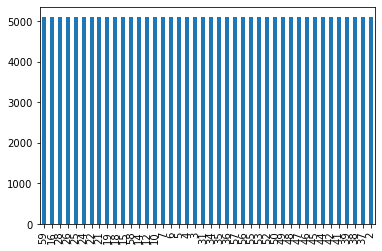

In [35]:
test["shop_id"].value_counts().plot(kind='bar')

In [42]:
test["shop_id"].value_counts()

59    5100
16    5100
28    5100
26    5100
25    5100
24    5100
22    5100
21    5100
19    5100
18    5100
15    5100
58    5100
14    5100
12    5100
10    5100
7     5100
6     5100
5     5100
4     5100
3     5100
31    5100
34    5100
35    5100
36    5100
57    5100
56    5100
55    5100
53    5100
52    5100
50    5100
49    5100
48    5100
47    5100
46    5100
45    5100
44    5100
42    5100
41    5100
39    5100
38    5100
37    5100
2     5100
Name: shop_id, dtype: int64

In [37]:
test["item_id"].value_counts().to_frame("item_count")["item_count"].value_counts()

42    5100
Name: item_count, dtype: int64

In [58]:
test["item_category_id"].value_counts().to_frame("category_count")

,category_count
40,32340
55,28224
37,13902
31,11634
58,9366
...,...
11,42
79,42
71,42
74,42


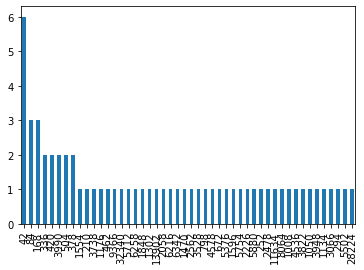

In [57]:
test["item_category_id"].value_counts().to_frame("category_count")["category_count"].value_counts().plot(kind='bar')

So there are 5100 items and all have been chosen 42 times and 42 shops and all have been chosen 5100 times. The categories are unevenly distributed, but it seems 42 is magic number too because 6 categories appear 42 tims and 3 categories 84 times and so on. However. 1. Time to investigate some leak? 2. It also implies that many shop-item combi may not exist in reality, that is, certain shops don't sell many of the items in the test set, result in a safe default values of 0.

In [50]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [174]:
sample_submission.item_cnt_month = 0

In [175]:
sample_submission.to_csv(os.path.join('./kaggle/output/all_0.csv'), index=False)

Submit an all 0 submission, the score is 1.250111 in public and 1.236582 in private. Not bad.

In [4]:
transactions_month = transactions.groupby(["item_shop", "date_block_num"])["item_cnt_day"].sum().to_frame("item_cnt_month").reset_index()



In [5]:
transactions_month.head()

,item_shop,date_block_num,item_cnt_month
0,0_54,20,1.0
1,10000_25,0,1.0
2,10000_25,5,1.0
3,10000_25,8,1.0
4,10000_25,11,1.0


In [6]:
len(transactions_month)

1609124

In [8]:
test = pd.merge(test, last_month_sale, on="item_shop", how="left").fillna(0)
test["item_cnt_month"] = test["item_cnt_month"].clip(0, 20)

In [11]:
test.head()

,ID,shop_id,item_id,item_category_id,item_shop,item_cnt_month
0,0,5,5037,19,5037_59,0.0
1,1,5,5320,55,5320_25,0.0
2,2,5,5233,19,5233_25,2.0
3,3,5,5232,23,5232_25,1.0
4,4,5,5268,20,5268_25,0.0


In [166]:

test["item_cnt_month"].value_counts()

0.0     184562
1.0      17532
2.0       5541
3.0       2427
4.0       1296
5.0        725
6.0        478
7.0        310
20.0       305
8.0        224
9.0        187
10.0       103
13.0        97
11.0        94
12.0        82
14.0        70
15.0        62
16.0        36
17.0        27
18.0        24
19.0        18
Name: item_cnt_month, dtype: int64

In [167]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [168]:
sample_submission.update(test)

In [172]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.0
1,1,0.0
2,2,2.0
3,3,1.0
4,4,0.0


In [171]:
sample_submission[["ID", "item_cnt_month"]].to_csv(os.path.join('./kaggle/output/last_month.csv'), index=False)

In [48]:
transactions.head()

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id,item_shop
0,0,01.09.2014,20,54,58.0,1.0,40,0_54
1,1,04.04.2014,15,55,4490.0,1.0,76,1_55
2,1,02.04.2014,15,55,4490.0,1.0,76,1_55
3,1,06.07.2014,18,55,4490.0,1.0,76,1_55
4,1,04.08.2014,19,55,4490.0,1.0,76,1_55


In [12]:
print (f"There are {len(test[~test.item_id.isin(transactions.item_id.unique())])} unique items in the test but not in transactions. And {len(test[test.item_id.isin(transactions.item_id.unique())])} in.")

There are 15246 unique items in the test but not in transactions. And 198954 in.


In [243]:
#df.groupby(['name'], as_index=False).agg({'value1': 'sum', 'value2': 'sum', 'otherstuff1': 'first', 'otherstuff2': 'first'})

all_data = transactions.groupby(["item_shop", "date_block_num"],  as_index=False).agg({"item_cnt_day": "sum", "shop_id":"first", "item_id": "first", "item_price": "mean", "item_category_id": "first"})
all_data.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)





#price_average = transactions.groupby(["item_shop"])["item_price"].mean().to_frame("item_price_average").reset_index()

In [244]:
all_data.head()

,item_shop,date_block_num,item_cnt_month,shop_id,item_id,item_price,item_category_id
0,0_54,20,1.0,54,0,58.0,40
1,10000_25,0,1.0,25,10000,499.0,37
2,10000_25,5,1.0,25,10000,199.0,37
3,10000_25,8,1.0,25,10000,199.0,37
4,10000_25,11,1.0,25,10000,199.0,37


In [245]:
assert 1609124 ==len(all_data)

In [246]:
all_data[all_data["item_category_id"] == 0]

,item_shop,date_block_num,item_cnt_month,shop_id,item_id,item_price,item_category_id
520742,16255_0,1,1.0,0,16255,93.0,0
520743,16256_38,3,1.0,38,16256,22.4,0
520744,16257_25,0,1.0,25,16257,148.0,0


In [247]:
test["date_block_num"] = transactions["date_block_num"].max() + 1
test["item_cnt_month"] = 0

In [248]:
test_no_id = test.copy()
test_no_id.drop("ID", axis=1, inplace=True)
test_no_id.head()

,item_id,shop_id,item_category_id,item_shop,date_block_num,item_cnt_month
0,30,5,40,30_5,34,0
1,30,4,40,30_4,34,0
2,30,6,40,30_6,34,0
3,30,3,40,30_3,34,0
4,30,2,40,30_2,34,0


In [249]:
all_data_sort = all_data.sort_values(by="date_block_num", ascending=False).drop_duplicates(subset=["item_shop"], keep="first")

all_data_dict =all_data_sort[["item_shop", "item_price"]].set_index('item_shop').T.to_dict('records')

In [250]:
all_data_dict[0]

{'1581_18': 4499.0,
 '2876_24': 2448.4,
 '7879_16': 3690.0,
 '2875_7': 699.3,
 '7879_10': 2209.0,
 '2876_16': 3499.0,
 '7878_59': 3198.0,
 '7878_42': 3198.0,
 '13903_19': 229.0,
 '7878_4': 3198.0,
 '7878_28': 3198.0,
 '2876_2': 2448.75,
 '7878_15': 3198.0,
 '13901_46': 399.0,
 '2876_28': 2448.7,
 '7877_6': 1998.0,
 '2876_34': 3499.0,
 '2876_37': 2449.0,
 '7877_49': 1998.0,
 '2876_38': 2448.7,
 '13901_57': 399.0,
 '7877_45': 1998.0,
 '7877_4': 1998.0,
 '2876_49': 3499.0,
 '2875_58': 699.3,
 '13903_31': 229.0,
 '15563_58': 399.0,
 '13903_38': 229.0,
 '2873_57': 849.15,
 '2873_7': 699.3,
 '2874_31': 999.0,
 '2874_47': 699.3,
 '7879_35': 3490.0,
 '2874_50': 999.0,
 '2874_57': 999.0,
 '7879_31': 3690.0,
 '2875_19': 699.3,
 '2875_2': 699.3,
 '2875_25': 699.3,
 '2875_35': 699.3,
 '2875_39': 699.3,
 '13903_5': 229.0,
 '10845_28': 349.0,
 '2875_42': 699.0,
 '15563_57': 399.0,
 '7879_24': 3690.0,
 '13903_41': 229.0,
 '13903_4': 229.0,
 '13903_39': 229.0,
 '2877_18': 3499.0,
 '2877_25': 2448.7,
 

In [251]:
#df2['Col2'] = df1.loc[df1.Col1 == df2.Col2, 'Col2']

test_no_id["item_price"] = test_no_id["item_shop"].map(all_data_dict[0])

In [252]:
test_no_id.head()

,item_id,shop_id,item_category_id,item_shop,date_block_num,item_cnt_month,item_price
0,30,5,40,30_5,34,0,129.0
1,30,4,40,30_4,34,0,399.0
2,30,6,40,30_6,34,0,129.0
3,30,3,40,30_3,34,0,129.0
4,30,2,40,30_2,34,0,169.0


In [120]:
"30_54" in all_data_dict[0]

True

In [142]:
len(test)

214200

In [253]:
all_data = pd.concat([all_data, test_no_id])

/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [8]:
len(train_test_together)

11128050

In [255]:
214200 + 1609124

1823324

In [9]:
train_test_together[train_test_together["date_block_num"] == 34]

,ID,date_block_num,item_category_id,item_id,shop_id,target,target_category,target_item,target_item_shop,target_shop
50190,0.0,34,0,5037,5,0.0,0.0,0.0,0.0,0.0
52668,1.0,34,0,5320,5,0.0,0.0,0.0,0.0,0.0
52038,2.0,34,0,5233,5,0.0,0.0,0.0,0.0,0.0
51996,3.0,34,0,5232,5,0.0,0.0,0.0,0.0,0.0
52290,4.0,34,0,5268,5,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
181565,214195.0,34,0,18454,45,0.0,0.0,0.0,0.0,0.0
163925,214196.0,34,0,16188,45,0.0,0.0,0.0,0.0,0.0
156281,214197.0,34,0,15757,45,0.0,0.0,0.0,0.0,0.0
191687,214198.0,34,0,19648,45,0.0,0.0,0.0,0.0,0.0


In [259]:
all_data.head()

,date_block_num,item_category_id,item_cnt_month,item_id,item_price,item_shop,shop_id,shop_month_sale,item_month_sale,category_shop_month_sale
0,20,40,1.0,0,58.0,0_54,54,5034.0,1.0,864.0
1,0,37,1.0,10000,499.0,10000_25,25,8215.0,1.0,662.0
2,5,37,1.0,10000,199.0,10000_25,25,8478.0,4.0,707.0
3,8,37,1.0,10000,199.0,10000_25,25,9251.0,3.0,717.0
4,11,37,1.0,10000,199.0,10000_25,25,12102.0,1.0,870.0


In [260]:
all_data.to_csv("./kaggle/output/all_data_without_lag.csv", index=False)

In [ ]:
all_data = pd.read_csv("./kaggle/output/all_data.csv")

In [261]:
lag_period = list(range(1,13))
lag_period

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [263]:
all_data[all_data["item_shop"] == "30_5"]

,date_block_num,item_category_id,item_cnt_month,item_id,item_price,item_shop,shop_id,shop_month_sale,item_month_sale,category_shop_month_sale,...,category_shop_month_sale_lag_3,category_shop_month_sale_lag_4,category_shop_month_sale_lag_5,category_shop_month_sale_lag_6,category_shop_month_sale_lag_7,category_shop_month_sale_lag_8,category_shop_month_sale_lag_9,category_shop_month_sale_lag_10,category_shop_month_sale_lag_11,category_shop_month_sale_lag_12
1026802,1,40,5.0,30,399.0,30_5,5,877.0,861.0,240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1026803,2,40,7.0,30,399.0,30_5,5,1355.0,508.0,357.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1026804,3,40,1.0,30,399.0,30_5,5,1008.0,130.0,268.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1026805,9,40,1.0,30,169.0,30_5,5,1267.0,24.0,275.0,...,0.0,0.0,0.0,268.0,357.0,240.0,0.0,0.0,0.0,0.0
1026806,12,40,1.0,30,169.0,30_5,5,1639.0,58.0,294.0,...,275.0,0.0,0.0,0.0,0.0,0.0,268.0,357.0,240.0,0.0
1026807,17,40,1.0,30,169.0,30_5,5,1326.0,13.0,234.0,...,0.0,0.0,294.0,0.0,0.0,275.0,0.0,0.0,0.0,0.0
1026808,18,40,1.0,30,169.0,30_5,5,1404.0,13.0,247.0,...,0.0,0.0,0.0,294.0,0.0,0.0,275.0,0.0,0.0,0.0
1026809,19,40,1.0,30,169.0,30_5,5,1536.0,12.0,230.0,...,0.0,0.0,0.0,0.0,294.0,0.0,0.0,275.0,0.0,0.0
1026810,31,40,1.0,30,129.0,30_5,5,1294.0,6.0,191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0
1609124,34,40,0.0,30,129.0,30_5,5,0.0,0.0,0.0,...,191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [264]:
len(all_data)

1823324

In [19]:
all_data =downcast_dtypes(all_data)

In [20]:
all_data.dtypes

ID                             int16
date_block_num                 int16
item_category_id               int16
item_id                        int16
shop_id                        int16
target                       float16
target_category              float16
target_item                  float16
target_item_shop             float16
target_shop                  float16
target_lag_1                 float16
target_lag_2                 float16
target_lag_3                 float16
target_lag_4                 float16
target_lag_5                 float16
target_lag_6                 float16
target_category_lag_1        float16
target_category_lag_2        float16
target_category_lag_3        float16
target_category_lag_4        float16
target_category_lag_5        float16
target_category_lag_6        float16
target_item_lag_1            float16
target_item_lag_2            float16
target_item_lag_3            float16
target_item_lag_4            float16
target_item_lag_5            float16
t

In [21]:
transactions

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id
0,0,01.09.2014,20,54,58.0,1.0,40
1,1,04.04.2014,15,55,4490.0,1.0,76
2,1,02.04.2014,15,55,4490.0,1.0,76
3,1,06.07.2014,18,55,4490.0,1.0,76
4,1,04.08.2014,19,55,4490.0,1.0,76
...,...,...,...,...,...,...,...
2935844,22168,02.02.2013,1,42,799.0,1.0,62
2935845,22168,17.02.2013,1,16,799.0,1.0,62
2935846,22168,08.03.2013,2,43,798.5,1.0,62
2935847,22168,13.09.2013,8,12,799.0,1.0,62


In [214]:
all_data.to_csv("./kaggle/output/all_data_w_lag.csv", index=False)

In [234]:
all_data = pd.read_csv("./kaggle/output/all_data_w_lag.csv")

In [230]:
features_to_drop = ["item_id", "item_category_id", "shop_id", "item_shop", "item_month_sale", "shop_month_sale", "category_shop_month_sale"]

features_selected = all_data.columns.difference(features_to_drop)



In [12]:
baseline_features

NameError: name 'baseline_features' is not defined

In [127]:
all_data.head()

,ID,date_block_num,item_category_id,item_id,shop_id,target,target_category,target_item,target_item_shop,target_shop,...,target_item_shop_lag_5,target_item_shop_lag_6,target_shop_lag_1,target_shop_lag_2,target_shop_lag_3,target_shop_lag_4,target_shop_lag_5,target_shop_lag_6,last_item_shop_sale_month,last_item_sale_month
0,-1,20,40,0,54,1.0,864.0,1.0,1.0,5032.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,50
1,-1,20,40,0,55,0.0,0.0,1.0,0.0,2248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,50
2,-1,20,40,0,56,0.0,446.0,1.0,0.0,1879.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,50
3,-1,20,40,0,44,0.0,181.0,1.0,0.0,1039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,50
4,-1,20,40,0,35,0.0,229.0,1.0,0.0,1941.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,50


In [19]:
new_features

['target_lag_1',
 'target_lag_2',
 'target_lag_3',
 'target_lag_4',
 'target_lag_5',
 'target_lag_6',
 'target_lag_7',
 'target_lag_8',
 'target_lag_9',
 'target_lag_10',
 'target_lag_11',
 'target_lag_12',
 'target_category_lag_1',
 'target_category_lag_2',
 'target_category_lag_3',
 'target_category_lag_4',
 'target_category_lag_5',
 'target_category_lag_6',
 'target_category_lag_7',
 'target_category_lag_8',
 'target_category_lag_9',
 'target_category_lag_10',
 'target_category_lag_11',
 'target_category_lag_12',
 'target_item_lag_1',
 'target_item_lag_2',
 'target_item_lag_3',
 'target_item_lag_4',
 'target_item_lag_5',
 'target_item_lag_6',
 'target_item_lag_7',
 'target_item_lag_8',
 'target_item_lag_9',
 'target_item_lag_10',
 'target_item_lag_11',
 'target_item_lag_12',
 'target_item_shop_lag_1',
 'target_item_shop_lag_2',
 'target_item_shop_lag_3',
 'target_item_shop_lag_4',
 'target_item_shop_lag_5',
 'target_item_shop_lag_6',
 'target_item_shop_lag_7',
 'target_item_shop_lag

In [14]:

baseline_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num'] +  new_features + ['target']


cat_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num']

for val_time in [27, 28, 29, 30, 31, 32]:

    train_time_range_lo = (all_data['date_block_num'] >= 12)
    train_time_range_hi =  (all_data['date_block_num'] < val_time)

    # val: want rows with date_block_num from 22
    validation_time =  (all_data['date_block_num'] == val_time)
    # Retrieve rows for train set, val set, test set
    cv_trainset = all_data[train_time_range_lo & train_time_range_hi]
    cv_valset = all_data[validation_time]

    
    train_x = cv_trainset[baseline_features]
    train_y = cv_trainset["target"]
    train_x.drop("target", axis=1, inplace=True)
    
    
    val_x = cv_valset[baseline_features]
    val_y = cv_valset["target"]
    val_x.drop("target", axis=1, inplace=True)

    
    #cv_trainset_vals = cv_trainset.values.astype(int)
    #trainx = cv_trainset_vals[:, 0:len(baseline_features) - 1]
    #trainy = cv_trainset_vals[:, len(baseline_features) - 1]

    #cv_valset_vals = cv_valset.values.astype(int)
    #valx = cv_valset_vals[:, 0:len(baseline_features) - 1]
    #valy = cv_valset_vals[:, len(baseline_features) - 1]
    
    #pool1 = Pool(data=trainx, label=trainy, cat_features=cat_features)
    
    
    #model = xgb.XGBRegressor(max_depth = 11, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 43, nthread = 16, tree_method="gpu_hist")
    model = CatBoostRegressor(iterations=100,
                          learning_rate=0.05,
                          depth=10,
                          task_type="GPU",
                          eval_metric='RMSE')
    
    #model.fit(train_x, train_y, cat_features)

    model.fit(
    train_x.astype(int), train_y.astype(int),
    cat_features=cat_features,
    #eval_set=(val_x.astype(int), val_y.astype(int)),
    logging_level='Silent'
    )
    
    preds = model.predict(val_x.astype(int))
    # Clipping to range 0-20
    preds = np.clip(preds, 0,20)
    #print (preds[:20])
    
    val_y = np.clip(val_y, 0,20).astype(int)
    print('val set rmse: ', sqrt(mean_squared_error(val_y, preds)))




/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


val set rmse:  0.9514091369662517


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


val set rmse:  0.9220950660226349


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


val set rmse:  0.8504075448627718


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


val set rmse:  0.7605385623209077


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


val set rmse:  0.8311653355648838


/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


val set rmse:  0.9802905757274119


In [15]:


#testset_vals = testset.values.astype(int)
#testx = testset_vals[:, 0:len(baseline_features) - 1]

# Prepare numpy arrays for training/val/test


In [17]:
train_time_range_lo = (all_data['date_block_num'] >= 12)
train_time_range_hi =  (all_data['date_block_num'] <= 33)

final_trainset = all_data[train_time_range_lo & train_time_range_hi]

#final_trainset = final_trainset.values.astype(int)
#trainx = final_trainset[:, 1:len(baseline_features) - 1]
#trainy = final_trainset[:, len(baseline_features) - 1]
train_x = final_trainset[baseline_features]
train_y = final_trainset["target"]
train_x.drop("target", axis=1, inplace=True)

model = CatBoostRegressor(iterations=100,
                          learning_rate=0.05,
                          depth=10,
                          task_type="GPU",
                          eval_metric='RMSE')
    
    #model.fit(train_x, train_y, cat_features)

model.fit(
train_x.astype(int), train_y.astype(int),
cat_features=cat_features,
#eval_set=(val_x.astype(int), val_y.astype(int)),
logging_level='Silent'
)

#model = xgb.XGBRegressor(max_depth = 11, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 43, nthread = 16, tree_method="gpu_hist")

model.fit(train_x, train_y)

0:	learn: 3.5423453	total: 92.7ms	remaining: 9.18s
1:	learn: 3.4693226	total: 174ms	remaining: 8.51s
2:	learn: 3.4090071	total: 262ms	remaining: 8.46s
3:	learn: 3.3461334	total: 348ms	remaining: 8.35s
4:	learn: 3.2855732	total: 432ms	remaining: 8.21s
5:	learn: 3.2315544	total: 518ms	remaining: 8.11s
6:	learn: 3.1782192	total: 598ms	remaining: 7.95s
7:	learn: 3.1338729	total: 686ms	remaining: 7.88s
8:	learn: 3.0852953	total: 770ms	remaining: 7.79s
9:	learn: 3.0425221	total: 852ms	remaining: 7.67s
10:	learn: 3.0006298	total: 946ms	remaining: 7.66s
11:	learn: 2.9640875	total: 1.04s	remaining: 7.66s
12:	learn: 2.9208974	total: 1.14s	remaining: 7.6s
13:	learn: 2.8885554	total: 1.22s	remaining: 7.47s
14:	learn: 2.8533705	total: 1.31s	remaining: 7.43s
15:	learn: 2.8227252	total: 1.4s	remaining: 7.37s
16:	learn: 2.7932631	total: 1.5s	remaining: 7.33s
17:	learn: 2.7632020	total: 1.59s	remaining: 7.23s
18:	learn: 2.7394020	total: 1.68s	remaining: 7.14s
19:	learn: 2.7174503	total: 1.76s	remaining

In [125]:
preds

array([20.       ,  0.3235699, 20.       , ..., 20.       , 20.       ,
       20.       ], dtype=float32)

In [18]:
preds = model.predict(test_x)
# Clipping to range 0-20
preds = np.clip(preds, 0,20)
df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df.index.name='ID'
#df['ID'] =

#df_update = pd.DataFrame.from_dict(unique_test_dict[0], orient='index')

#df_update.columns = ["item_cnt_month"]


#df.update(df_update)

#test_no_id["item_price"] = test_no_id["item_shop"].map(all_data_dict[0])

#df = df.set_index('ID')

df.to_csv('test_preds.csv')

In [121]:
final_trainset

array([[-1, 20, 40, ...,  0, 50, 50],
       [-1, 20, 40, ...,  0, 50, 50],
       [-1, 20, 40, ...,  0, 50, 50],
       ...,
       [-1, 14, 69, ...,  0, 50, 50],
       [-1, 14, 69, ...,  0, 50, 50],
       [-1, 14, 69, ...,  0, 50, 50]])

In [123]:
trainx

array([[   20,    40,     0, ...,     0,     0,     0],
       [   20,    40,     0, ...,     0,     0,     0],
       [   20,    40,     0, ...,     0,     0,     0],
       ...,
       [   14,    69, 22169, ...,     0,     0,     0],
       [   14,    69, 22169, ...,     0,     0,     0],
       [   14,    69, 22169, ...,     0,     0,     0]])

In [124]:
testx

array([[ 5037,     0,    34, ...,  1012,     2,     1],
       [ 5320,     0,    34, ...,     0,    50,    50],
       [ 5233,     0,    34, ...,  1012,     1,     1],
       ...,
       [15757,     0,    34, ...,   762,    50,     1],
       [19648,     0,    34, ...,   762,    50,     1],
       [  969,     0,    34, ...,   762,    50,     1]])

In [188]:
testx.head()

,category_shop_month_sale_lag_1,category_shop_month_sale_lag_10,category_shop_month_sale_lag_11,category_shop_month_sale_lag_12,category_shop_month_sale_lag_2,category_shop_month_sale_lag_3,category_shop_month_sale_lag_4,category_shop_month_sale_lag_5,category_shop_month_sale_lag_6,category_shop_month_sale_lag_7,...,shop_month_sale_lag_11,shop_month_sale_lag_12,shop_month_sale_lag_2,shop_month_sale_lag_3,shop_month_sale_lag_4,shop_month_sale_lag_5,shop_month_sale_lag_6,shop_month_sale_lag_7,shop_month_sale_lag_8,shop_month_sale_lag_9
1609124,0.0,0.0,0.0,0.0,0.0,191.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1294.0,0.0,0.0,0.0,0.0,0.0,0.0
1609125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1609126,0.0,301.0,383.0,340.0,198.0,0.0,0.0,0.0,0.0,0.0,...,4115.0,3150.0,1725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1609127,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,535.0,0.0,0.0,0.0,0.0,0.0
1609128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
train_test_together    = pd.read_csv(os.path.join('./top_11_train_test_set.csv'))


In [14]:
train_test_together.head()

,Unnamed: 0,Unnamed: 0.1,date_block_num,item_cnt_month,item_id,item_price,shop_id,item_category_id,prev_shopitem_sales_1,prev_shopitem_sales_2,...,prev_shopitem_price_3,prev_shopitem_price_4,prev_shopitem_price_5,prev_shopitem_price_6,prev_item_price_1,prev_item_price_2,prev_item_price_3,prev_item_price_4,prev_item_price_5,prev_item_price_6
0,0,0.0,0,1.0,22154,999.0,59,11,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,5.0,22154,999.0,25,11,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.0,0,1.0,22154,999.0,24,11,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.0,0,0.0,22154,NaN,23,11,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4.0,0,0.0,22154,NaN,19,11,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
new_features = ['prev_shopitem_sales_1',
 'prev_shopitem_sales_2',
 'prev_shopitem_sales_3',
 'prev_shopitem_sales_4',
 'prev_shopitem_sales_5',
 'prev_shopitem_sales_6',
 'prev_item_sales_1',
 'prev_item_sales_2',
 'prev_item_sales_3',
 'prev_item_sales_4',
 'prev_item_sales_5',
 'prev_item_sales_6',
 'prev_shopitem_price_1',
 'prev_shopitem_price_2',
 'prev_shopitem_price_3',
 'prev_shopitem_price_4',
 'prev_shopitem_price_5',
 'prev_shopitem_price_6',
 'prev_item_price_1',
 'prev_item_price_2',
 'prev_item_price_3',
 'prev_item_price_4',
 'prev_item_price_5',
 'prev_item_price_6']

In [4]:
baseline_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num'] +  new_features + ['item_cnt_month']


cat_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num']

for val_time in [27, 28, 29, 30, 31, 32]:

    train_time_range_lo = (train_test_together['date_block_num'] >= 6)
    train_time_range_hi =  (train_test_together['date_block_num'] < val_time)

    # val: want rows with date_block_num from 22
    validation_time =  (train_test_together['date_block_num'] == val_time)
    # Retrieve rows for train set, val set, test set
    cv_trainset = train_test_together[train_time_range_lo & train_time_range_hi]
    cv_valset = train_test_together[validation_time]

    
    train_x = cv_trainset[baseline_features]
    train_y = cv_trainset["item_cnt_month"]
    train_x.drop("item_cnt_month", axis=1, inplace=True)
    
    
    val_x = cv_valset[baseline_features]
    val_y = cv_valset["item_cnt_month"]
    val_x.drop("item_cnt_month", axis=1, inplace=True)

    
    #cv_trainset_vals = cv_trainset.values.astype(int)
    #trainx = cv_trainset_vals[:, 0:len(baseline_features) - 1]
    #trainy = cv_trainset_vals[:, len(baseline_features) - 1]

    #cv_valset_vals = cv_valset.values.astype(int)
    #valx = cv_valset_vals[:, 0:len(baseline_features) - 1]
    #valy = cv_valset_vals[:, len(baseline_features) - 1]
    
    #pool1 = Pool(data=trainx, label=trainy, cat_features=cat_features)
    
    
    #model = xgb.XGBRegressor(max_depth = 11, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 254, nthread = 16, tree_method="gpu_hist")
    model = CatBoostRegressor(iterations=100, learning_rate=0.05, depth=10, task_type="GPU", eval_metric='RMSE')
    
    #model.fit(train_x, train_y, cat_features)

    model.fit(
    train_x, train_y,
    cat_features=cat_features
    #eval_set=(val_x.astype(int), val_y.astype(int)),
    #logging_level='Silent'
    )
    
    preds = model.predict(val_x)
    # Clipping to range 0-20
    preds = np.clip(preds, 0,20)
    #print (preds[:20])
    
    val_y = np.clip(val_y, 0,20)
    print('val set rmse: ', sqrt(mean_squared_error(val_y, preds)))




/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0:	learn: 1.2232770	total: 140ms	remaining: 13.8s
1:	learn: 1.1970695	total: 275ms	remaining: 13.5s
2:	learn: 1.1726879	total: 411ms	remaining: 13.3s
3:	learn: 1.1502791	total: 553ms	remaining: 13.3s
4:	learn: 1.1293484	total: 691ms	remaining: 13.1s
5:	learn: 1.1098283	total: 829ms	remaining: 13s
6:	learn: 1.0919827	total: 967ms	remaining: 12.8s
7:	learn: 1.0753867	total: 1.11s	remaining: 12.8s
8:	learn: 1.0598927	total: 1.25s	remaining: 12.6s
9:	learn: 1.0455546	total: 1.38s	remaining: 12.4s
10:	learn: 1.0322237	total: 1.52s	remaining: 12.3s
11:	learn: 1.0195914	total: 1.67s	remaining: 12.2s
12:	learn: 1.0082419	total: 1.8s	remaining: 12.1s
13:	learn: 0.9975562	total: 1.94s	remaining: 11.9s
14:	learn: 0.9875606	total: 2.09s	remaining: 11.8s
15:	learn: 0.9782950	total: 2.24s	remaining: 11.8s
16:	learn: 0.9701236	total: 2.37s	remaining: 11.6s
17:	learn: 0.9621433	total: 2.52s	remaining: 11.5s
18:	learn: 0.9547901	total: 2.67s	remaining: 11.4s
19:	learn: 0.9478530	total: 2.81s	remaining:

SystemError: <method '_train' of '_catboost._CatBoost' objects> returned a result with an error set

In [21]:
train_time_range_lo = (train_test_together['date_block_num'] >= 6)
train_time_range_hi =  (train_test_together['date_block_num'] <= 33)

final_trainset = train_test_together[train_time_range_lo & train_time_range_hi]

#final_trainset = final_trainset.values.astype(int)
#trainx = final_trainset[:, 1:len(baseline_features) - 1]
#trainy = final_trainset[:, len(baseline_features) - 1]
train_x = final_trainset[baseline_features]
train_y = final_trainset["item_cnt_month"]
train_x.drop("item_cnt_month", axis=1, inplace=True)

#model = xgb.XGBRegressor(max_depth = 11, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 254, nthread = 16)

    
    #model.fit(train_x, train_y, cat_features)

#model.fit(train_x.astype(int), train_y.astype(int))

#model = xgb.XGBRegressor(max_depth = 11, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 43, nthread = 16, tree_method="gpu_hist")
model = CatBoostRegressor(iterations=100, learning_rate=0.05, depth=10, task_type="GPU", eval_metric='RMSE')


#model.fit(train_x, train_y)
model.fit(
    train_x, train_y,
    cat_features=cat_features
    #eval_set=(val_x.astype(int), val_y.astype(int)),
    #logging_level='Silent'
    )

/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0:	learn: 1.1956439	total: 172ms	remaining: 17s
1:	learn: 1.1710275	total: 342ms	remaining: 16.8s
2:	learn: 1.1478757	total: 514ms	remaining: 16.6s
3:	learn: 1.1266759	total: 680ms	remaining: 16.3s
4:	learn: 1.1070151	total: 851ms	remaining: 16.2s
5:	learn: 1.0885013	total: 1.02s	remaining: 16.1s
6:	learn: 1.0712828	total: 1.2s	remaining: 16s
7:	learn: 1.0554549	total: 1.36s	remaining: 15.7s
8:	learn: 1.0407662	total: 1.54s	remaining: 15.6s
9:	learn: 1.0271517	total: 1.71s	remaining: 15.4s
10:	learn: 1.0145330	total: 1.88s	remaining: 15.2s
11:	learn: 1.0028341	total: 2.04s	remaining: 15s
12:	learn: 0.9917977	total: 2.21s	remaining: 14.8s
13:	learn: 0.9821974	total: 2.38s	remaining: 14.6s
14:	learn: 0.9727813	total: 2.56s	remaining: 14.5s
15:	learn: 0.9640055	total: 2.73s	remaining: 14.3s
16:	learn: 0.9559629	total: 2.91s	remaining: 14.2s
17:	learn: 0.9484156	total: 3.08s	remaining: 14.1s
18:	learn: 0.9417942	total: 3.24s	remaining: 13.8s
19:	learn: 0.9353743	total: 3.41s	remaining: 13.

In [32]:
gc.collect()

19295

In [23]:
# test: want rows with date_block_num from 34
test_time =  (train_test_together['date_block_num'] == 34)

testset = train_test_together[test_time]


test_x = testset[baseline_features]
#train_x = cv_trainset[baseline_features]
test_x.drop("item_cnt_month", axis=1, inplace=True)


preds = model.predict(test_x)
# Clipping to range 0-20
preds = np.clip(preds, 0,20)
df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df.index.name='ID'


df.to_csv('catboost_top_11_preds.csv')

/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
train_time_range_lo = (train_test_together['date_block_num'] >= 6)
train_time_range_hi =  (train_test_together['date_block_num'] <= 33)

final_trainset = train_test_together[train_time_range_lo & train_time_range_hi]

#final_trainset = final_trainset.values.astype(int)
#trainx = final_trainset[:, 1:len(baseline_features) - 1]
#trainy = final_trainset[:, len(baseline_features) - 1]
train_x = final_trainset[baseline_features]
train_y = final_trainset["item_cnt_month"]
train_x.drop("item_cnt_month", axis=1, inplace=True)

model = xgb.XGBRegressor(max_depth = 11, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 1, nthread = 16)
model.fit(train_x, train_y, eval_metric='rmse')

/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[18:24:13] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:24:13] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=11, min_child_weight=0.5, missing=None, n_estimators=100,
             n_jobs=1, nthread=16, num_round=1000, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=1, silent=None, subsample=1, verbosity=1)

In [25]:
test_time =  (train_test_together['date_block_num'] == 34)

testset = train_test_together[test_time]


test_x = testset[baseline_features]
#train_x = cv_trainset[baseline_features]
test_x.drop("item_cnt_month", axis=1, inplace=True)


preds = model.predict(test_x)
# Clipping to range 0-20
preds = np.clip(preds, 0,20)
df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df.index.name='ID'


df.to_csv('xgboost_top_11_preds.csv')

/home/sih13/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
gc.collect()

16976

In [43]:
train_x.head()

,shop_id,item_id,item_category_id,date_block_num,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6,...,target_item_shop_lag_3,target_item_shop_lag_4,target_item_shop_lag_5,target_item_shop_lag_6,target_shop_lag_1,target_shop_lag_2,target_shop_lag_3,target_shop_lag_4,target_shop_lag_5,target_shop_lag_6
0,5,0,40,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0,40,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0,40,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0,40,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,0,40,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_test_together.head()